In [1]:
import pandas as pd
import numpy as np
import tensorflow
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns

/home/Yusuf/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv("Data/texts_and_fin.csv")
df.head()

,Unnamed: 0,ticker,cik,doc_name,txt_link,GICS Sector,text,release_date,items,price_change,vix,rm_week,rm_month,rm_qtr,rm_year,signal
0,0,A,1090872,0001564590-18-006570.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,0001564590-18-006570.txt : 20180322 0001564590...,2018-03-22 16:22:07,['Item 5.07'],0.28,23.34,-0.41,-3.07,2.01,26.67,stay
1,1,A,1090872,0001090872-18-000002.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,0001090872-18-000002.txt : 20180214 0001090872...,2018-02-14 16:27:02,"['Item 2.02', 'Item 2.02', 'Item 9.01']",7.22,19.26,1.95,-5.76,-3.94,35.67,up
2,2,A,1090872,0001564590-18-000605.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,0001564590-18-000605.txt : 20180118 0001564590...,2018-01-18 16:09:52,"['Item 5.02', 'Item 9.01']",0.47,12.22,1.22,5.17,3.38,39.20,stay
3,3,A,1090872,0001090872-17-000015.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,0001090872-17-000015.txt : 20171120 0001090872...,2017-11-20 16:09:02,"['Item 2.02', 'Item 2.02', 'Item 9.01']",0.31,10.65,2.71,1.31,10.13,40.26,stay
4,4,A,1090872,0001090872-17-000011.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,0001090872-17-000011.txt : 20170815 0001090872...,2017-08-15 16:12:29,"['Item 2.02', 'Item 2.02', 'Item 9.01']",5.19,12.04,-0.21,-3.34,4.39,21.40,up


In [3]:
df['release_date'] = df['release_date'].map(lambda x: pd.to_datetime(x))
df['items'] = df['items'].map(lambda x: ast.literal_eval(x))

## Text PreProcessing
1. Remove extra whitespace
2. Tokenize
3. Remove punctuation, stopwords, convert to lower case
4. Lemmatize
5. Load pre-trained word embeddings

In [3]:
# import spacy
# from nltk.corpus import stopwords
# import string
# import matplotlib.pyplot as plt
# import seaborn as sns

# stop_words = stopwords.words("english")
# nlp = spacy.load("en_core_web_sm")
# nlp.max_length = 76131683

# punctuations = string.punctuation

from nltk.corpus import stopwords
stop_words = stopwords.words("english")
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
wordnet_lemmatizer = WordNetLemmatizer()
import string
punctuations = string.punctuation
import matplotlib.pyplot as plt
import seaborn as sns

import dask.dataframe as dd
from dask.multiprocessing import get
from dask.diagnostics import ProgressBar

In [4]:
def cleanup_text(doc, logging=False):
    doc = re.sub( '\s+', ' ', doc ).strip()
    doc = nlp(doc, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc]
    tokens = [tok for tok in tokens if tok.isalpha()]
    tokens = [tok for tok in tokens if tok not in stop_words and tok not in punctuations]
    tokens_len = len(tokens)
    tokens = ' '.join(tokens)
    return tokens,tokens_len

def nltk_tokenizer(text):
    try:
        tokens = [word for word in word_tokenize(text) if word.isalpha()]
        tokens = list(filter(lambda t: t not in punctuations, tokens))
        tokens = list(filter(lambda t: t.lower() not in stop_words, tokens))
        filtered_tokens = []
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
        filtered_tokens = list(
            map(lambda token: wordnet_lemmatizer.lemmatize(token.lower()), filtered_tokens))
        filtered_tokens = list(filter(lambda t: t not in punctuations, filtered_tokens))
        return filtered_tokens
    except Exception as e:
        raise e

def dask_tokenizer(df):
    df['processed_text'] = df['text'].map(nltk_tokenizer)
    df['text_len'] = df['processed_text'].map(lambda x: len(x))
    return df

In [8]:
pbar = ProgressBar()
pbar.register()
ddata = dd.from_pandas(df, npartitions=20)
df = ddata.map_partitions(dask_tokenizer).compute(get=get)

[                                        ] | 0% Completed |  8min 40.5s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[                                        ] | 0% Completed | 11min 28.6s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#########                               ] | 22% Completed | 30min 14.2s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[############################            ] | 70% Completed | 46min 56.1s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[################################        ] | 80% Completed | 52min 58.2s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed |  1hr  8min  7.7s
[########################################] | 100% Completed |  1hr  8min  7.8s
[########################################] | 100% Completed |  1hr  8min  7.9s


In [9]:
df.head()

,Unnamed: 0,ticker,cik,doc_name,txt_link,GICS Sector,text,release_date,items,price_change,vix,rm_week,rm_month,rm_qtr,rm_year,signal,processed_text,text_len
0,0,A,1090872,0001564590-18-006570.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,0001564590-18-006570.txt : 20180322 0001564590...,2018-03-22 16:22:07,['Item 5.07'],0.28,23.34,-0.41,-3.07,2.01,26.67,stay,"[accession, number, conformed, submission, typ...",310
1,1,A,1090872,0001090872-18-000002.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,0001090872-18-000002.txt : 20180214 0001090872...,2018-02-14 16:27:02,"['Item 2.02', 'Item 2.02', 'Item 9.01']",7.22,19.26,1.95,-5.76,-3.94,35.67,up,"[accession, number, conformed, submission, typ...",2005
2,2,A,1090872,0001564590-18-000605.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,0001564590-18-000605.txt : 20180118 0001564590...,2018-01-18 16:09:52,"['Item 5.02', 'Item 9.01']",0.47,12.22,1.22,5.17,3.38,39.20,stay,"[accession, number, conformed, submission, typ...",815
3,3,A,1090872,0001090872-17-000015.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,0001090872-17-000015.txt : 20171120 0001090872...,2017-11-20 16:09:02,"['Item 2.02', 'Item 2.02', 'Item 9.01']",0.31,10.65,2.71,1.31,10.13,40.26,stay,"[accession, number, conformed, submission, typ...",1794
4,4,A,1090872,0001090872-17-000011.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,0001090872-17-000011.txt : 20170815 0001090872...,2017-08-15 16:12:29,"['Item 2.02', 'Item 2.02', 'Item 9.01']",5.19,12.04,-0.21,-3.34,4.39,21.40,up,"[accession, number, conformed, submission, typ...",1816


In [ ]:
df.to_csv("Data/lemmatized_text.csv",chunksize=1000)

In [120]:
df = pd.read_csv("Data/lemmatized_text.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,ticker,cik,doc_name,txt_link,GICS Sector,text,release_date,items,price_change,vix,rm_week,rm_month,rm_qtr,rm_year,signal,processed_text,text_len
0,0,0,A,1090872,0001564590-18-006570.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,0001564590-18-006570.txt : 20180322 0001564590...,2018-03-22 16:22:07,['Item 5.07'],0.28,23.34,-0.41,-3.07,2.01,26.67,stay,"['accession', 'number', 'conformed', 'submissi...",310
1,1,1,A,1090872,0001090872-18-000002.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,0001090872-18-000002.txt : 20180214 0001090872...,2018-02-14 16:27:02,"['Item 2.02', 'Item 2.02', 'Item 9.01']",7.22,19.26,1.95,-5.76,-3.94,35.67,up,"['accession', 'number', 'conformed', 'submissi...",2005
2,2,2,A,1090872,0001564590-18-000605.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,0001564590-18-000605.txt : 20180118 0001564590...,2018-01-18 16:09:52,"['Item 5.02', 'Item 9.01']",0.47,12.22,1.22,5.17,3.38,39.20,stay,"['accession', 'number', 'conformed', 'submissi...",815
3,3,3,A,1090872,0001090872-17-000015.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,0001090872-17-000015.txt : 20171120 0001090872...,2017-11-20 16:09:02,"['Item 2.02', 'Item 2.02', 'Item 9.01']",0.31,10.65,2.71,1.31,10.13,40.26,stay,"['accession', 'number', 'conformed', 'submissi...",1794
4,4,4,A,1090872,0001090872-17-000011.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,0001090872-17-000011.txt : 20170815 0001090872...,2017-08-15 16:12:29,"['Item 2.02', 'Item 2.02', 'Item 9.01']",5.19,12.04,-0.21,-3.34,4.39,21.40,up,"['accession', 'number', 'conformed', 'submissi...",1816


In [121]:
df.drop(['Unnamed: 0','Unnamed: 0.1',"doc_name",'txt_link','text'],axis=1,inplace=True)
df['items'] = df['items'].map(lambda x: ast.literal_eval(x))
df['items'] = df['items'].map(lambda items: [' '.join(x.split()) for x in items])

/home/Yusuf/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


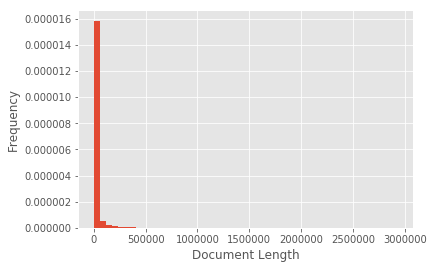

In [122]:
plt.style.use("ggplot")
df['text_len'].plot.hist(bins=50,normed=True)
plt.xlabel("Document Length")
plt.show()

In [123]:
int(df['text_len'].quantile(.9))

34603

In [124]:
df['text_len'].describe()

count    1.671000e+04
mean     1.951087e+04
std      7.462709e+04
min      9.500000e+01
25%      6.800000e+02
50%      1.902500e+03
75%      8.176750e+03
max      2.934190e+06
Name: text_len, dtype: float64

In [125]:
df['ticker'].nunique()

425

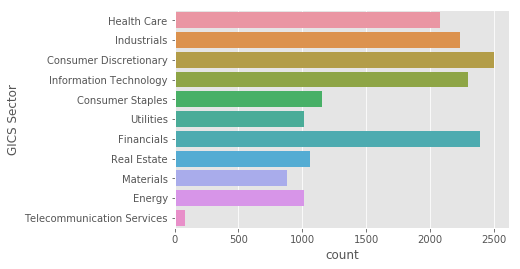

In [126]:
sns.countplot(y=df['GICS Sector'])
plt.savefig("Graphs/sectors.png",format="png")
plt.show()

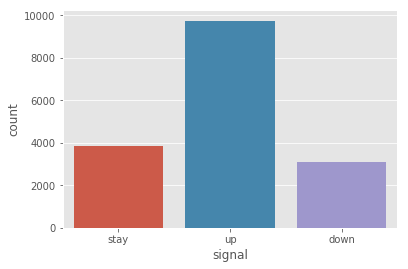

In [127]:
#Count plot of signals
sns.countplot(df['signal'])
plt.show()

Classes are imbalanced, will need to adjust

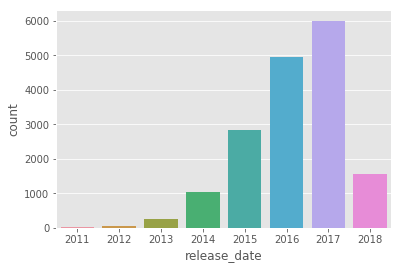

In [128]:
df['release_date'] = df['release_date'].map(lambda x: pd.to_datetime(x))
sns.countplot(pd.DatetimeIndex(df['release_date']).year)
plt.savefig("Graphs/year_balances.png",format="png")
plt.show()